# Preprocessing an Audio Dataset

## Resampling Audio Data

The ```load_dataset``` function downloads audio examples with the sampling rate that they were published with. This is not always the sampling rate expected by a model you plan to train, or use for inference. If there’s a discrepancy between the sampling rates, you can resample the audio to the model’s expected sampling rate.

Most of the available pretrained models have been pretrained on audio datasets at a sampling rate of 16 kHz. When we explored MINDS-14 dataset, you may have noticed that it is sampled at 8 kHz, which means we will likely need to upsample it.

To do so, use HuggingFace Datasets’ ```cast_column``` method. This operation does not change the audio in-place, but rather signals to datasets to resample the audio examples on the fly when they are loaded. The following code will set the sampling rate to 16kHz
- Use upsampling methods to increase the sampling rate from 8kHz to 16kHz

In [1]:
"""
We can download and prepare a dataset using the load_dataset() function

MINDS-14: Audio dataset containing recordings of people asking an e-banking system questions 
in several languages and dialects
"""

from datasets import load_dataset

# Copy the dataset's identifier on the hub and also indicate that we are only interested in the Australian subset
minds = load_dataset("PolyAI/minds14", name="en-AU", split="train", trust_remote_code=True)

In [2]:
from datasets import Audio

# cast_column method resamples audio examples on the fly when they are loaded. 
minds = minds.cast_column("audio", Audio(sampling_rate=16_000))

In [3]:
# RELOAD the first audio example in the MINDS-14 dataset
# It has been resampled the desired sampling rate of 16 000
minds[0]

{'path': 'C:\\Users\\User\\.cache\\huggingface\\datasets\\downloads\\extracted\\228c65c1896234a72340aa696a64db8fd3a27186eb6ea260edf1336dad208a46\\en-AU~PAY_BILL\\response_4.wav',
 'audio': {'path': 'C:\\Users\\User\\.cache\\huggingface\\datasets\\downloads\\extracted\\228c65c1896234a72340aa696a64db8fd3a27186eb6ea260edf1336dad208a46\\en-AU~PAY_BILL\\response_4.wav',
  'array': array([2.36120541e-05, 1.92325111e-04, 2.19284673e-04, ...,
         9.40908678e-04, 1.16613181e-03, 7.20883720e-04]),
  'sampling_rate': 16000},
 'transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'english_transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'intent_class': 13,
 'lang_id': 2}

## Filtering the Dataset

Common use case: Limit audio examples to a certain duration - we might want to filter out examples longer than 20s to prevent out-of-memor errors when training a model

Do this by using HuggingFace Dataset's ```filter``` method and passing a function with filtering logic to it 

```
MAX_DURATION_IN_SECONDS = 20.0


def is_audio_length_in_range(input_length):
    return input_length < MAX_DURATION_IN_SECONDS
```

Helps to indicate which examples to keep and which to discard
Returns True if a sample is shorter than 20s and False if it is longer than 20s


In [4]:
import librosa


MAX_DURATION_IN_SECONDS = 20.0


def is_audio_length_in_range(input_length):
    return input_length < MAX_DURATION_IN_SECONDS

"""
The original dataset does not have an audio track duration 

Therefore we need to create one, use it for filtering and remove it after
"""

# use librosa to get example's duration from the audio file
new_column = [librosa.get_duration(path=x) for x in minds["path"]]
minds = minds.add_column("duration", new_column)

# use HuggingFace Datasets' `filter` method to apply the filtering function
minds = minds.filter(is_audio_length_in_range, input_columns=["duration"])

# Remove the temporary helper column
minds = minds.remove_columns(["duration"])
minds

Filter:   0%|          | 0/654 [00:00<?, ? examples/s]

Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 624
})

Check that the results only have 624 examples, down from 654 examples previously

## Preprocessing the audio

Raw audio data comes as an array of sample values.

Pre-trained models expect the raw data to be converted into input features whether we use them for inference or fine-tuning.
- Requirements for the input features may vary from one model to another. It depends on the model's architecture and the data it was pre-trained with

For HuggingFace:
- For every supported audio model, HuggingFace Transformers offer a feature extractor class that can convert raw audio data into the input features the model expects

What does a ```feature extractor``` do with raw audio data, to convert it into the input features that the model expects?

```Whisper's feature extractor``` as an example

1. Whisper feature extractor pads a batch of audio examples such that all examples have an input length of 30s
- Examples shorter than this are padded to 30s by appending 0s to the end of the sequence (0s in an audio signal correspond to no signal or silence)
- Examples longer than 30s are truncated to 30s
- Whisper is trained to operate without an attention mask and infer directly from the speech signals where to ignore the inputs

2. Whisper feature extractor converts the padded audio arrays to log-mel sepctograms 
- Recall:  These spectrograms describe how the frequencies of a signal change over time, expressed on the mel scale and measured in decibels (the log part) to make the frequencies and amplitudes more representative of human hearing

```
# Load the feature extractor from the pre-trained Whisper checkpoint
from transformers import WhisperFeatureExtractor

feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small")
```

In [6]:
from transformers import WhisperFeatureExtractor

feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small")

preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\User\.cache\huggingface\hub\models--openai--whisper-small. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [7]:
"""
Write a function to pre-process a single audio example by passing it 
through the feature_extractor    
"""

def prepare_dataset(example):
    audio = example["audio"]
    features = feature_extractor(
        audio["array"], sampling_rate=audio["sampling_rate"], padding=True
    )
    return features


"""
Apply the data preparation function to all of our training examples using 
HuggingFace Datasets’ map method
"""

minds = minds.map(prepare_dataset)
minds

Map:   0%|          | 0/624 [00:00<?, ? examples/s]

Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id', 'input_features'],
    num_rows: 624
})

We now have log-mel spectrograms as input_features in the dataset

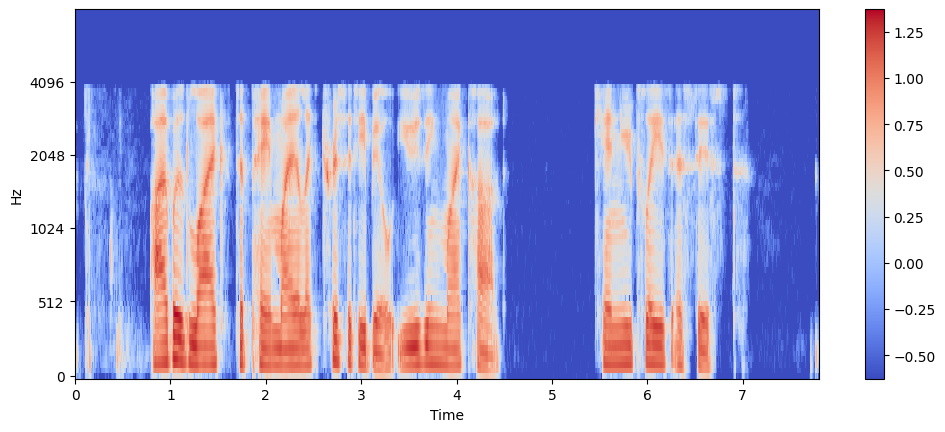

In [10]:
import numpy as np
import matplotlib.pyplot as plt

example = minds[0]
input_features = example["input_features"]

plt.figure().set_figwidth(12)
librosa.display.specshow(
    np.asarray(input_features[0]),
    x_axis="time",
    y_axis="mel",
    sr=feature_extractor.sampling_rate,
    hop_length=feature_extractor.hop_length,
)
plt.colorbar()

The model’s feature extractor class takes care of transforming raw audio data to the format that the model expects

You can load the feature extractor and tokenizer for Whisper and other multimodal models separately, or you can load both via a so-called processor. 

To make things even simpler, use AutoProcessor to load a model’s feature extractor and processor from a checkpoint, like this

```
from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained("openai/whisper-small")
```

See more on performing custom data transformations:
https://huggingface.co/docs/datasets/audio_process